In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import legendre
import seaborn as sns

# Set the style
sns.set_palette("husl")

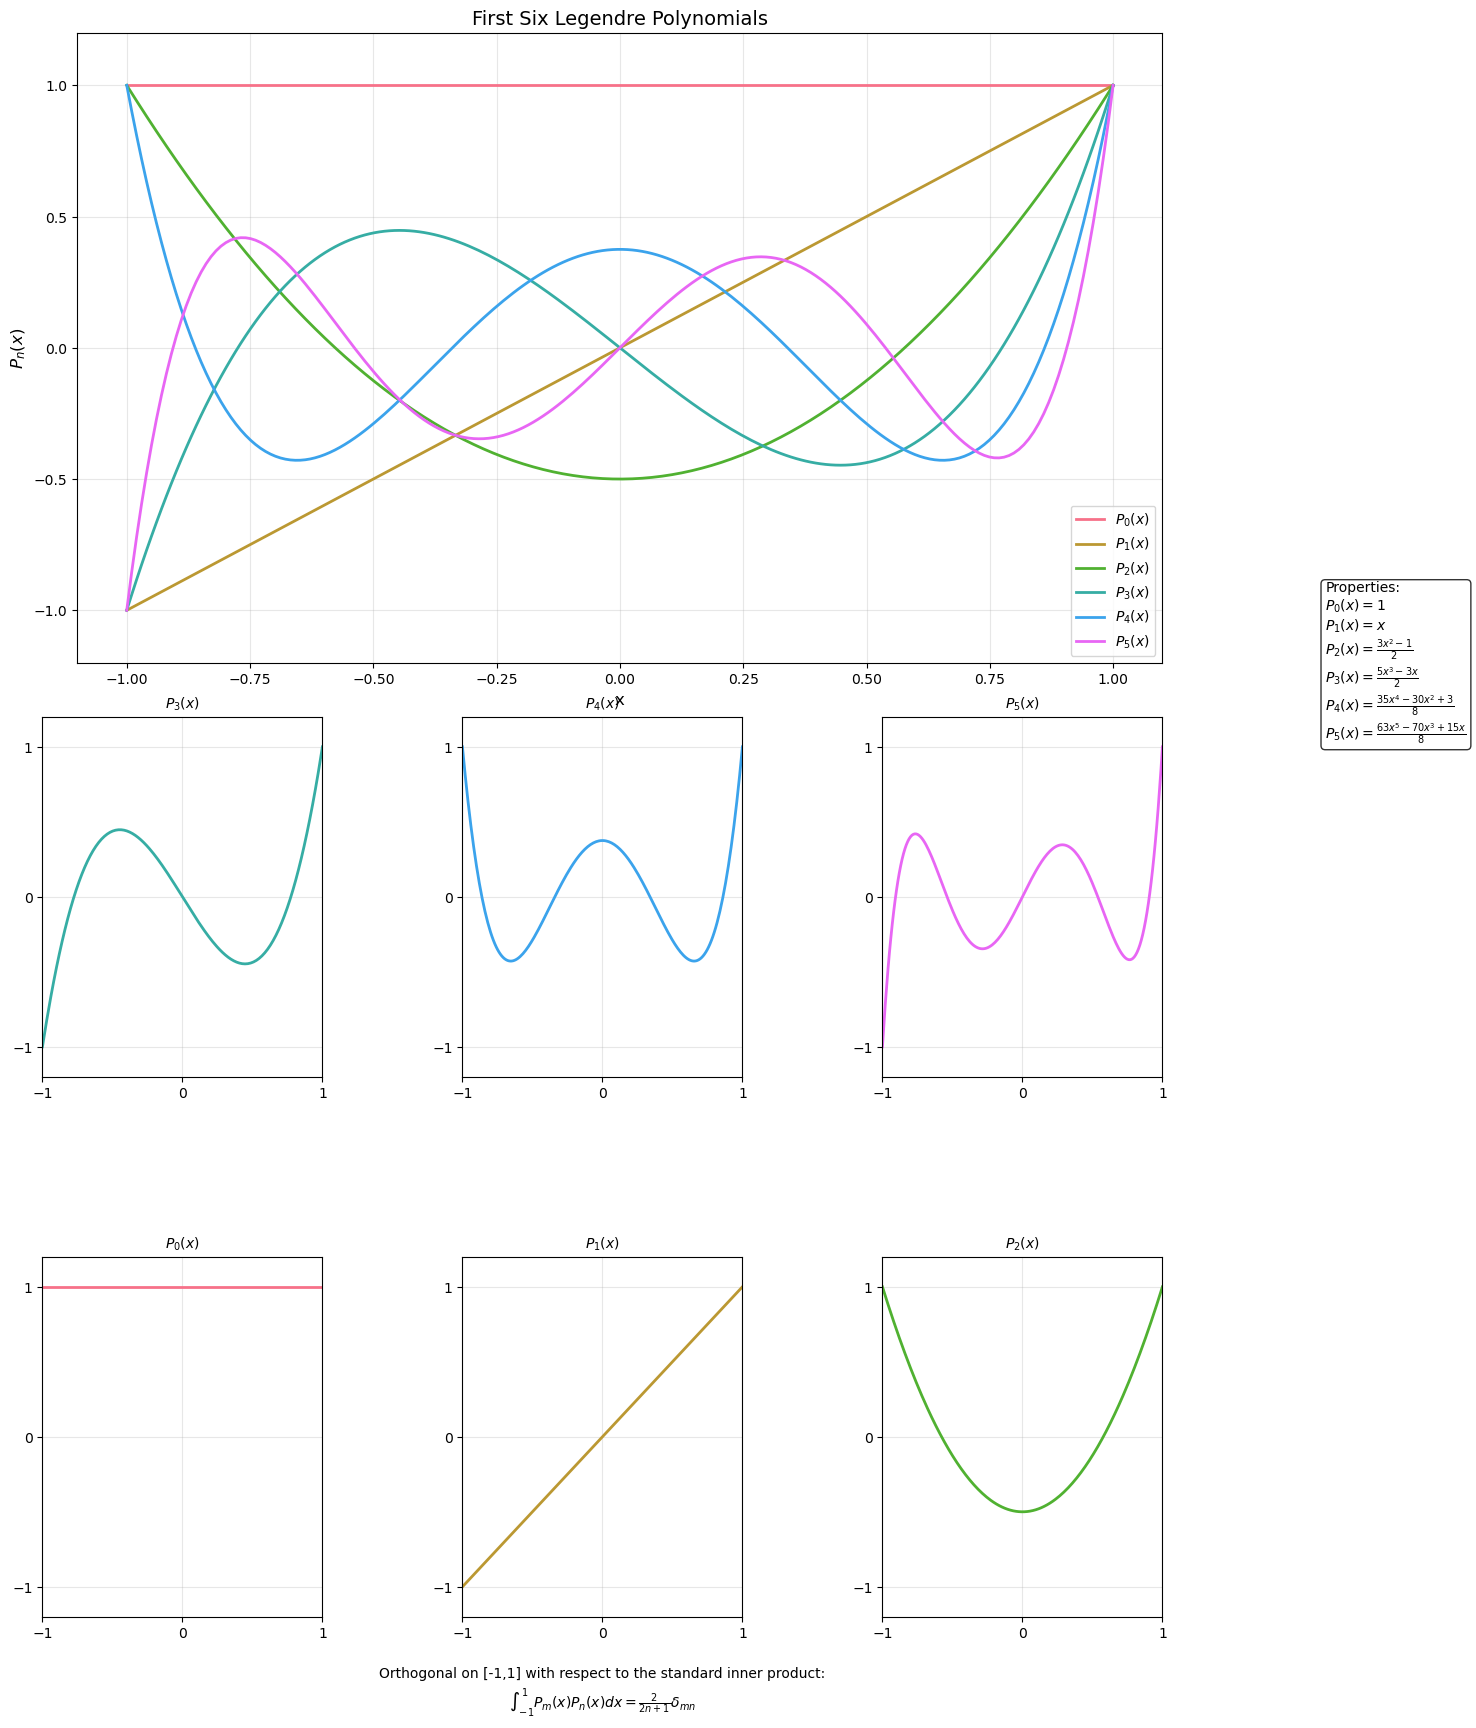


Polynomial Properties:

P_0(x):
Number of zeros: 0
Zeros: []

P_1(x):
Number of zeros: 1
Zeros: [-0.001001]

P_2(x):
Number of zeros: 2
Zeros: [-0.57757758  0.57557558]

P_3(x):
Number of zeros: 3
Zeros: [-0.77577578 -0.001001    0.77377377]

P_4(x):
Number of zeros: 4
Zeros: [-0.86186186 -0.34134134  0.33933934  0.85985986]

P_5(x):
Number of zeros: 5
Zeros: [-0.90790791 -0.53953954 -0.001001    0.53753754  0.90590591]


In [2]:
# Create figure
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 18))

# Generate points for x-axis
x = np.linspace(-1, 1, 200)

# Plot first 6 Legendre polynomials
degrees = range(6)
colors = sns.husl_palette(len(degrees))
labels = [f'$P_{i}(x)$' for i in degrees]

# First plot: All polynomials
for i, (color, label) in enumerate(zip(colors, labels)):
    poly = legendre(i)
    ax1.plot(x, poly(x), label=label, color=color, linewidth=2)

ax1.grid(True, alpha=0.3)
ax1.set_xlabel('x', fontsize=12)
ax1.set_ylabel('$P_n(x)$', fontsize=12)
ax1.set_title('First Six Legendre Polynomials', fontsize=14)
ax1.legend(fontsize=10)
ax1.set_ylim(-1.2, 1.2)

# Add explanatory text
props = dict(boxstyle='round', facecolor='white', alpha=0.8)
text = ("Properties:\n"
        "$P_0(x) = 1$\n"
        "$P_1(x) = x$\n"
        "$P_2(x) = \\frac{3x^2 - 1}{2}$\n"
        "$P_3(x) = \\frac{5x^3 - 3x}{2}$\n"
        "$P_4(x) = \\frac{35x^4 - 30x^2 + 3}{8}$\n"
        "$P_5(x) = \\frac{63x^5 - 70x^3 + 15x}{8}$")
ax1.text(1.15, 0, text, transform=ax1.transAxes, fontsize=10,
         verticalalignment='center', bbox=props)
# Second plot: Individual polynomials
x_reshaped = x.reshape(-1, 1)
num_cols = 3
num_rows = 2
for i in range(len(degrees)):
    row = i // num_cols
    col = i % num_cols
    
    # Create small subplot
    pos = [0.1 + col * 0.3, 0 + row * 0.3, 0.2, 0.2]
    ax_sub = fig.add_axes(pos)
    
    # Plot polynomial
    poly = legendre(i)
    ax_sub.plot(x, poly(x), color=colors[i], linewidth=2)
    ax_sub.grid(True, alpha=0.3)
    ax_sub.set_xlim(-1, 1)
    ax_sub.set_ylim(-1.2, 1.2)
    ax_sub.set_title(f'$P_{i}(x)$', fontsize=10)
    
    # Remove ticks for cleaner look
    ax_sub.set_xticks([-1, 0, 1])
    ax_sub.set_yticks([-1, 0, 1])

# Remove the empty second subplot
ax2.remove()

# Add title about orthogonality
fig.text(0.5, -0.05, 
         'Orthogonal on [-1,1] with respect to the standard inner product:\n' + 
         r'$\int_{-1}^1 P_m(x)P_n(x)dx = \frac{2}{2n+1}\delta_{mn}$',
         ha='center', fontsize=10)

plt.savefig('legendre_polynomials.png', dpi=300, bbox_inches='tight')
plt.show()

# Print zeros and extrema for each polynomial
print("\nPolynomial Properties:")
for i in degrees:
    poly = legendre(i)
    # Find zeros (approximately)
    x_fine = np.linspace(-1, 1, 1000)
    y = poly(x_fine)
    zeros = x_fine[np.where(np.diff(np.signbit(y)))[0]]
    
    print(f"\nP_{i}(x):")
    print(f"Number of zeros: {len(zeros)}")
    print(f"Zeros: {zeros}")

In [3]:
import pandas as pd
data = pd.read_csv('data/polynomial_data.csv')
data.head()

,x,y,y_true
0,-0.999343,-0.054806,0.012722
1,-0.980996,-0.404141,0.014133
2,-0.953654,-0.507817,0.016485
3,-0.894386,0.424916,0.022755
4,-0.886798,0.021913,0.023687


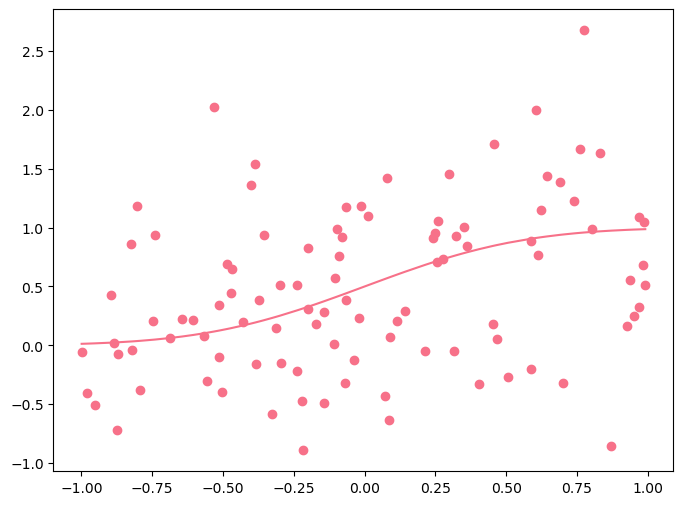

In [4]:
x = data['x'].values
y = data['y'].values
y_true = data['y_true'].values
x_grid = np.linspace(-1, 1, 1000)  # For smooth curve plotting
plt.figure(figsize = (8, 6))
plt.scatter(x, y)
plt.plot(x, y_true);

In [5]:
from sklearn.model_selection import train_test_split
x_train_full, x_test, y_train_full, y_test = train_test_split(
    x, y, test_size=0.4, random_state=42
)

In [6]:
import torch
import torch.nn as nn
from scipy.special import legendre

In [7]:
class LegendrePolynomialModel(nn.Module):
    def __init__(self, degree):
        super().__init__()
        self.degree = degree
        # One weight per polynomial degree (including constant term)
        self.linear = nn.Linear(self.degree + 1, 1)
        
    def legendre_features(self, X):
        # Generate Legendre polynomial features
        features = torch.ones(X.shape[0], self.degree + 1)
        X_np = X.detach().numpy()
        # print("shape", features.shape, features[:,0].shape, X_np.shape)
        
        for i in range(self.degree + 1):
            leg_poly = legendre(i)
            features[:, i] = torch.tensor(leg_poly(X_np).flatten(), dtype=torch.float32)
        
        return features
    
    def forward(self, X):
        features = self.legendre_features(X)
        return self.linear(features)

In [8]:
def create_model(degree):
    model = LegendrePolynomialModel(degree)
    return model

In [9]:
# GD based training
def train_model(model, x_train, y_train, num_epochs=100, lr=0.01):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    X_train_tensor = torch.tensor(x_train, dtype=torch.float32).reshape(-1, 1)
    Y_train_tensor = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)

    losses = []
    for epoch in range(num_epochs):
        # Forward pass
        outputs = model(X_train_tensor)
        loss = criterion(outputs, Y_train_tensor)
        # print("loss", loss)
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % 100 == 0:  # Save loss every 100 epochs
            losses.append(loss.item())

    #print("Loss", loss)
    return losses

In [10]:
def evaluate_model(model, x, y):
    with torch.no_grad():
        X_tensor = torch.tensor(x, dtype=torch.float32).reshape(-1, 1)
        Y_tensor = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)
        Y_pred = model(X_tensor)
        mse = nn.MSELoss()(Y_pred, Y_tensor)
    return mse.item()

In [11]:
def run_bias_variance_experiment(degree, num_trials=100):
    models = []
    train_errors = []
    val_errors = []
    test_errors = []
    
    for trial in range(num_trials):
        # Random 35-25 split of the training data
        x_train, x_val, y_train, y_val = train_test_split(
            x_train_full, y_train_full, 
            train_size=35/60, random_state=trial
        )
        
        model = create_model(degree)
        train_model(model, x_train, y_train)
        
        # Evaluate errors
        train_err = evaluate_model(model, x_train, y_train)
        val_err = evaluate_model(model, x_val, y_val)
        test_err = evaluate_model(model, x_test, y_test)
        
        train_errors.append(train_err)
        val_errors.append(val_err)
        test_errors.append(test_err)
        models.append(model)
    
    return models, train_errors, val_errors, test_errors

In [12]:
def plot_fits(models, degree, x_grid):
    plt.figure(figsize=(12, 6))
    
    # Plot all model predictions
    with torch.no_grad():
        X_tensor = torch.tensor(x_grid, dtype=torch.float32).reshape(-1, 1)
        for model in models:
            Y_pred = model(X_tensor).numpy()
            plt.plot(X_tensor, Y_pred, 'b-', alpha=0.1)
    
    # Plot training data
    plt.scatter(x_train_full, y_train_full, c='r', alpha=0.5, label='Training Data')
    plt.scatter(x_test, y_test, c='g', alpha=0.5, label='Test Data')
    
    plt.title(f'Polynomial Fits (degree={degree}, {len(models)} trials)')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.grid(True)
    plt.ylim(-1,2)
    plt.show()


Running experiment for degree 2
Average training error: 0.3476 ± 0.0594
Average validation error: 0.4110 ± 0.0972
Average test error: 0.5653 ± 0.0231


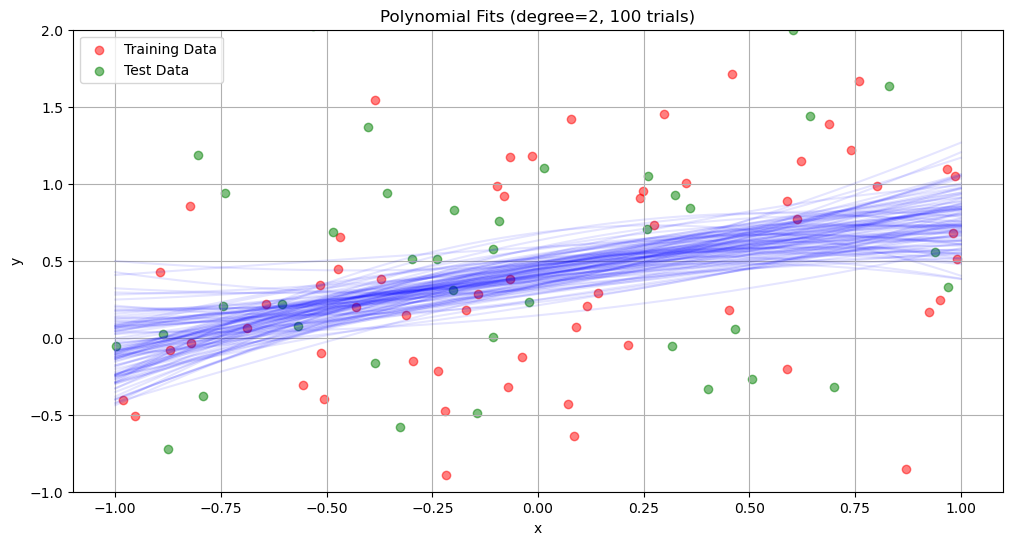


Running experiment for degree 6
Average training error: 0.3012 ± 0.0521
Average validation error: 0.4673 ± 0.1076
Average test error: 0.6093 ± 0.0649


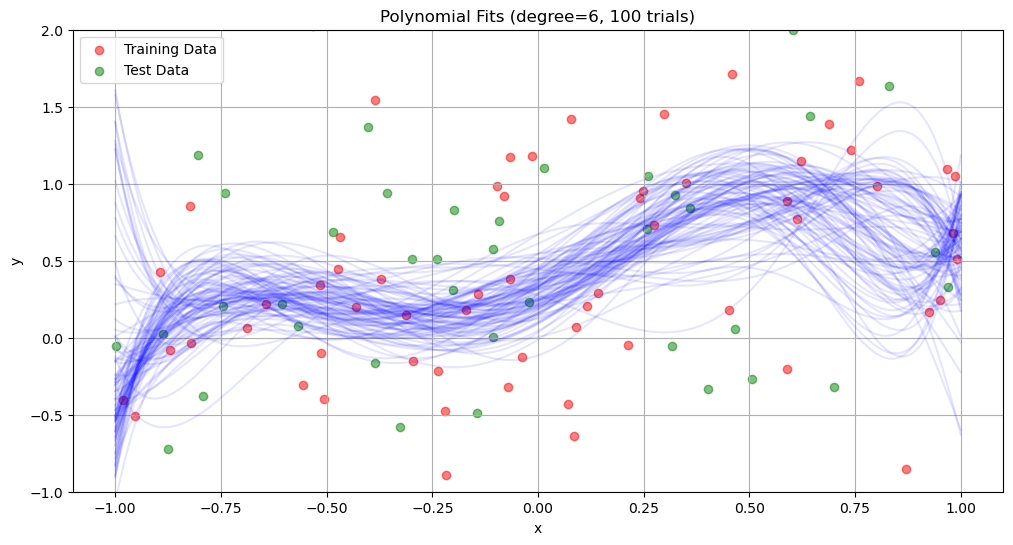


Running experiment for degree 13
Average training error: 0.2300 ± 0.0471
Average validation error: 0.4640 ± 0.1048
Average test error: 0.6672 ± 0.0765


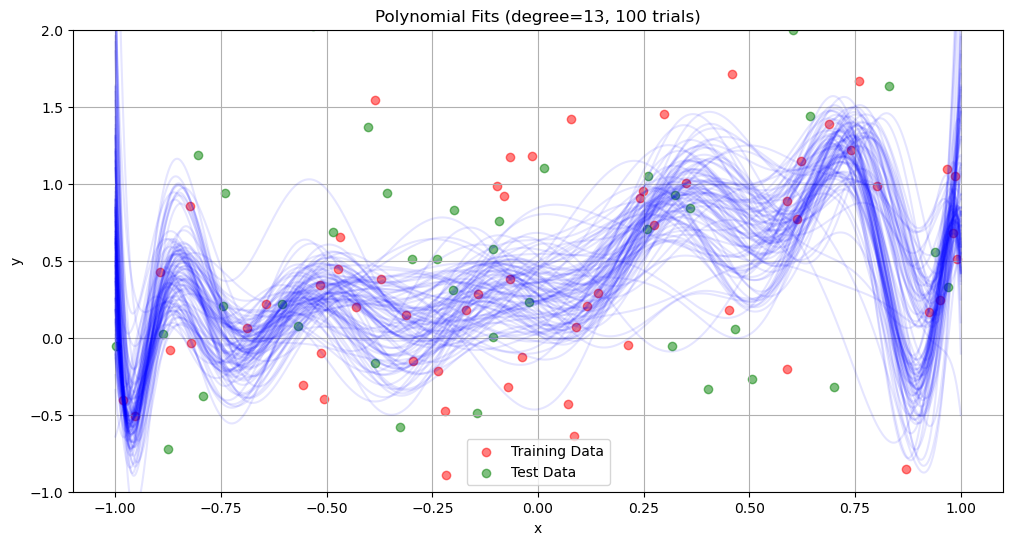


Running experiment for degree 15
Average training error: 0.1929 ± 0.0404
Average validation error: 0.4326 ± 0.1104
Average test error: 0.6958 ± 0.0851


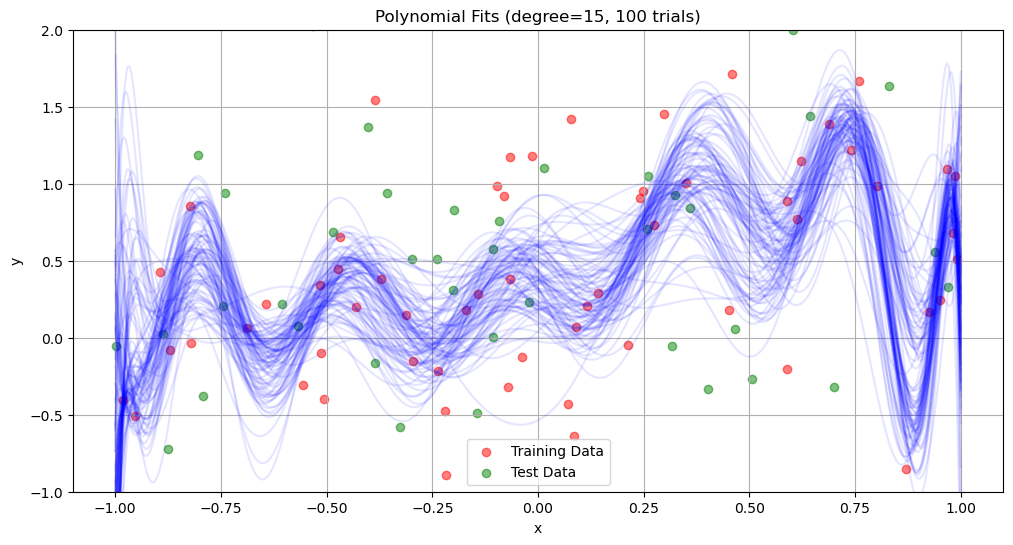


Running experiment for degree 30
Average training error: 0.1217 ± 0.0333
Average validation error: 0.4716 ± 0.1151
Average test error: 0.7772 ± 0.1101


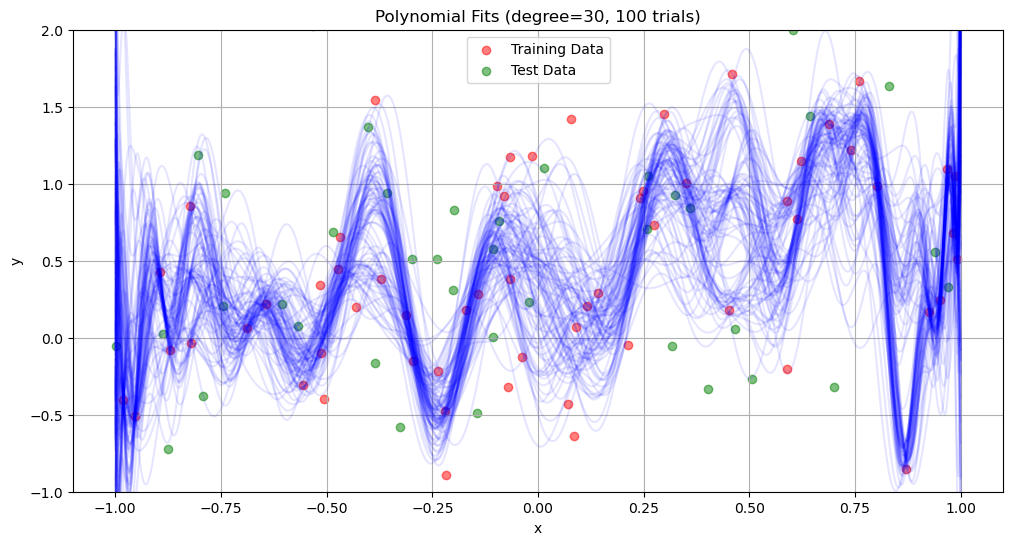

In [13]:
# Run experiments for both low and high degrees
degrees = [2, 6, 13, 15, 30]  # Low and high degree polynomials
for degree in degrees:
    print(f"\nRunning experiment for degree {degree}")
    models, train_errs, val_errs, test_errs = run_bias_variance_experiment(degree)
    
    print(f"Average training error: {np.mean(train_errs):.4f} ± {np.std(train_errs):.4f}")
    print(f"Average validation error: {np.mean(val_errs):.4f} ± {np.std(val_errs):.4f}")
    print(f"Average test error: {np.mean(test_errs):.4f} ± {np.std(test_errs):.4f}")
    
    plot_fits(models, degree, x_grid)

In [14]:
# Fixed train-validation split (35-25 from training set)
x_train, x_val, y_train, y_val = train_test_split(
    x_train_full, y_train_full, 
    train_size=35/60, random_state=0  # Fixed seed for reproducibility
)

# Train models of increasing degree
max_degree = 35
degrees = range(1, max_degree + 1)
results = []

for degree in degrees:
    print(f"Training model with degree {degree}")
    model = LegendrePolynomialModel(degree)
    losses = train_model(model, x_train, y_train, num_epochs=1000, lr=0.01)
    
    train_err = evaluate_model(model, x_train, y_train)
    val_err = evaluate_model(model, x_val, y_val)
    test_err = evaluate_model(model, x_test, y_test)
    
    result = {
        'degree': degree,
        'train_error': train_err,
        'val_error': val_err,
        'test_error': test_err,
        'final_loss': losses[-1],
        'model': model
    }
    print(f"Training error: {train_err:.6f}")
    print(f"Validation error: {val_err:.6f}")
    results.append(result)
# Save results for visualization

df_results = pd.DataFrame(results).drop('model', axis=1)
# Find optimal degree based on validation error
best_degree = df_results.loc[df_results['val_error'].idxmin(), 'degree']
best_model = results[best_degree - 1]
df_results.to_csv('data/training_results.csv', index=False)

Training model with degree 1
Training error: 0.233605
Validation error: 0.603406
Training model with degree 2
Training error: 0.233346
Validation error: 0.599722
Training model with degree 3
Training error: 0.216326
Validation error: 0.607713
Training model with degree 4
Training error: 0.184708
Validation error: 0.629677
Training model with degree 5
Training error: 0.180766
Validation error: 0.616978
Training model with degree 6
Training error: 0.179453
Validation error: 0.617729
Training model with degree 7
Training error: 0.179425
Validation error: 0.621299
Training model with degree 8
Training error: 0.178210
Validation error: 0.632499
Training model with degree 9
Training error: 0.177838
Validation error: 0.646607
Training model with degree 10
Training error: 0.173232
Validation error: 0.633731
Training model with degree 11
Training error: 0.171060
Validation error: 0.656480
Training model with degree 12
Training error: 0.170934
Validation error: 0.657024
Training model with degre

In [15]:
df_results

,degree,train_error,val_error,test_error,final_loss
0,1,0.233605,0.603406,0.620890,0.233605
1,2,0.233346,0.599722,0.622454,0.233346
2,3,0.216326,0.607713,0.668296,0.216326
3,4,0.184708,0.629677,0.616443,0.184708
4,5,0.180766,0.616978,0.639635,0.180766
5,6,0.179453,0.617729,0.648974,0.179453
6,7,0.179425,0.621299,0.647681,0.179425
7,8,0.178210,0.632499,0.653207,0.178210
8,9,0.177838,0.646607,0.654495,0.177838
9,10,0.173232,0.633731,0.633637,0.173232


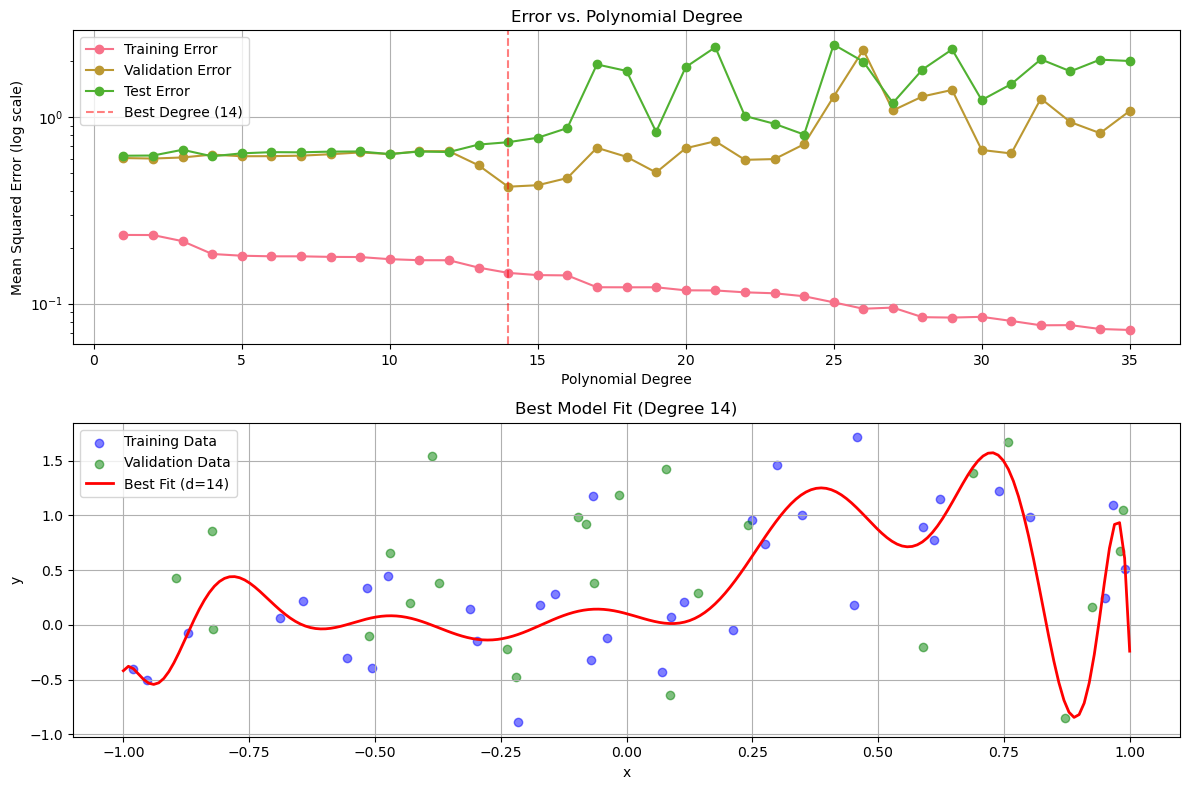


Detailed Results:
Best polynomial degree: 14

Errors for best model:
Training error: 0.146270
Validation error: 0.423682
Test error: 0.733712


In [16]:
# Plot results
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)

# Plot errors
plt.plot(df_results['degree'], df_results['train_error'], 'o-', label='Training Error')
plt.plot(df_results['degree'], df_results['val_error'], 'o-', label='Validation Error')
plt.plot(df_results['degree'], df_results['test_error'], 'o-', label='Test Error')

plt.axvline(x=best_degree, color='r', linestyle='--', alpha=0.5, 
            label=f'Best Degree ({best_degree})')

plt.yscale('log')
plt.xlabel('Polynomial Degree')
plt.ylabel('Mean Squared Error (log scale)')
plt.title('Error vs. Polynomial Degree')
plt.legend()
plt.grid(True)

# Plot predictions of best model
plt.subplot(2, 1, 2)
x_plot = np.linspace(-1, 1, 200)
with torch.no_grad():
    X_tensor = torch.tensor(x_plot, dtype=torch.float32).reshape(-1, 1)
    Y_pred = best_model['model'](X_tensor).numpy()

plt.scatter(x_train, y_train, c='b', label='Training Data', alpha=0.5)
plt.scatter(x_val, y_val, c='g', label='Validation Data', alpha=0.5)
plt.plot(x_plot, Y_pred, 'r-', label=f'Best Fit (d={best_degree})', linewidth=2)

plt.xlabel('x')
plt.ylabel('y')
plt.title(f'Best Model Fit (Degree {best_degree})')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('optimal_degree_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Print detailed results
print("\nDetailed Results:")
print(f"Best polynomial degree: {best_degree}")
print("\nErrors for best model:")
print(f"Training error: {results[best_degree-1]['train_error']:.6f}")
print(f"Validation error: {results[best_degree-1]['val_error']:.6f}")
print(f"Test error: {results[best_degree-1]['test_error']:.6f}")


In [17]:
from torch.utils.data import DataLoader, TensorDataset
def train_model_sgd(model, x_train, y_train, batch_size=6, num_epochs=3000, lr=0.01):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    # Create dataset and loader for mini-batches
    X_tensor = torch.tensor(x_train, dtype=torch.float32).reshape(-1, 1)
    Y_tensor = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
    dataset = TensorDataset(X_tensor, Y_tensor)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    # Track losses for each epoch
    epoch_losses = []
    
    for epoch in range(num_epochs):
        batch_losses = []
        for batch_x, batch_y in loader:
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            batch_losses.append(loss.item())
        
        # Average loss for this epoch
        epoch_loss = np.mean(batch_losses)
        epoch_losses.append(epoch_loss)
        
        # Print progress every 100 epochs
        if (epoch + 1) % 500 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.6f}")
    
    return epoch_losses

In [18]:
# Train models well beyond interpolation threshold
max_degree = 60
degrees = [1, 10, 13, 15, 20, 30, 35, 45, 50, 55, 57, 60, 62, 65, 75]
batch_sizes = [4, 6, 8]  # Try different batch sizes
results = []

for batch_size in batch_sizes:
    print(f"\nTraining with batch size {batch_size}")
    for degree in degrees:
        print(f"Training degree {degree}")
        model = LegendrePolynomialModel(degree)
        losses = train_model_sgd(model, x_train, y_train, batch_size=batch_size)
        
        train_err = evaluate_model(model, x_train, y_train)
        val_err = evaluate_model(model, x_val, y_val)
        test_err = evaluate_model(model, x_test, y_test)
        
        results.append({
            'degree': degree,
            'batch_size': batch_size,
            'train_error': train_err,
            'val_error': val_err,
            'test_error': test_err,
            'final_loss': losses[-1],
            'model': model
        })

# Convert results to DataFrame
df_results = pd.DataFrame([
    {k: v for k, v in r.items() if k != 'model'} 
    for r in results
])


Training with batch size 4
Training degree 1
Epoch 500/3000, Loss: 0.235512
Epoch 1000/3000, Loss: 0.236800
Epoch 1500/3000, Loss: 0.236790
Epoch 2000/3000, Loss: 0.230778
Epoch 2500/3000, Loss: 0.240962
Epoch 3000/3000, Loss: 0.238307
Training degree 10
Epoch 500/3000, Loss: 0.171942
Epoch 1000/3000, Loss: 0.175449
Epoch 1500/3000, Loss: 0.169887
Epoch 2000/3000, Loss: 0.171777
Epoch 2500/3000, Loss: 0.186854
Epoch 3000/3000, Loss: 0.175983
Training degree 13
Epoch 500/3000, Loss: 0.157587
Epoch 1000/3000, Loss: 0.156378
Epoch 1500/3000, Loss: 0.152946
Epoch 2000/3000, Loss: 0.166316
Epoch 2500/3000, Loss: 0.166285
Epoch 3000/3000, Loss: 0.154594
Training degree 15
Epoch 500/3000, Loss: 0.143419
Epoch 1000/3000, Loss: 0.140689
Epoch 1500/3000, Loss: 0.148554
Epoch 2000/3000, Loss: 0.144325
Epoch 2500/3000, Loss: 0.143983
Epoch 3000/3000, Loss: 0.142907
Training degree 20
Epoch 500/3000, Loss: 0.118582
Epoch 1000/3000, Loss: 0.121722
Epoch 1500/3000, Loss: 0.129638
Epoch 2000/3000, Lo

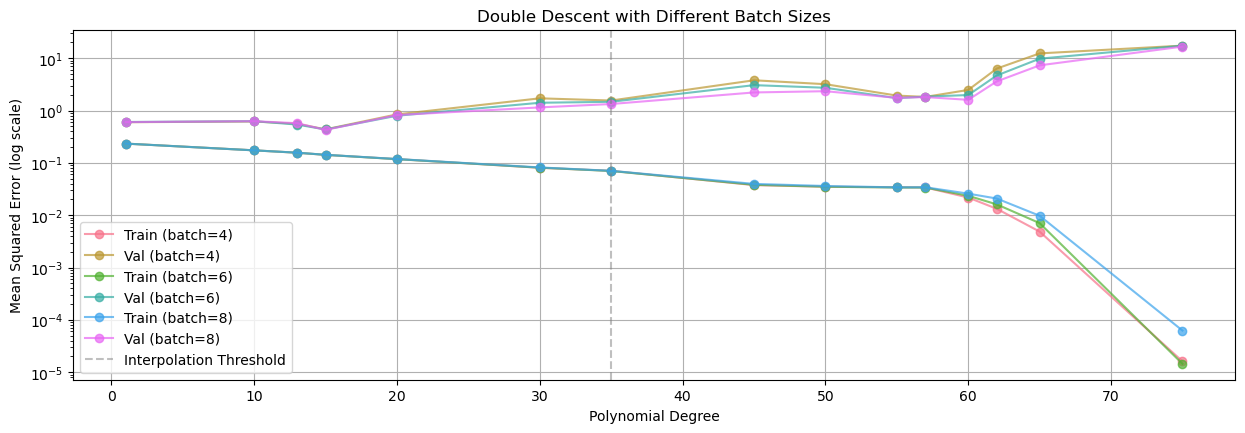

In [19]:
# Create visualization
plt.figure(figsize=(15, 10))

# Plot 1: Error curves for different batch sizes
plt.subplot(2, 1, 1)
for batch_size in batch_sizes:
    batch_data = df_results[df_results['batch_size'] == batch_size]
    plt.plot(batch_data['degree'], batch_data['train_error'], 
             'o-', label=f'Train (batch={batch_size})', alpha=0.7)
    plt.plot(batch_data['degree'], batch_data['val_error'], 
             'o-', label=f'Val (batch={batch_size})', alpha=0.7)

plt.axvline(x=35, color='gray', linestyle='--', alpha=0.5, 
            label='Interpolation Threshold')
plt.yscale('log')
plt.xlabel('Polynomial Degree')
plt.ylabel('Mean Squared Error (log scale)')
plt.title('Double Descent with Different Batch Sizes')
plt.legend()
plt.grid(True)

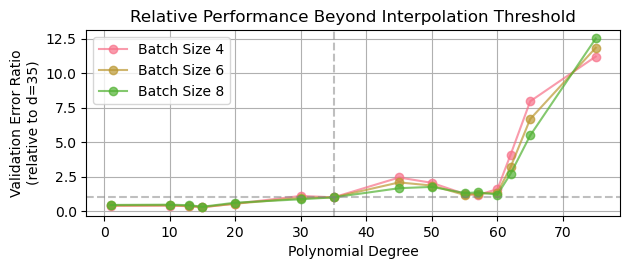


Best Results for Each Batch Size:

Batch Size 4:
Best degree: 15.0
Validation error: 0.437158
Training error: 0.142396
Test error: 0.780277

Batch Size 6:
Best degree: 15.0
Validation error: 0.434861
Training error: 0.142413
Test error: 0.775344

Batch Size 8:
Best degree: 15.0
Validation error: 0.427239
Training error: 0.142794
Test error: 0.764379


In [33]:
# Plot 2: Validation error ratio compared to interpolation threshold
plt.subplot(2, 1, 2)
for batch_size in batch_sizes:
    batch_data = df_results[df_results['batch_size'] == batch_size]
    interp_error = batch_data[batch_data['degree'] == 35]['val_error'].iloc[0]
    error_ratios = batch_data['val_error'] / interp_error
    plt.plot(batch_data['degree'], error_ratios, 
             'o-', label=f'Batch Size {batch_size}', alpha=0.7)

plt.axhline(y=1, color='gray', linestyle='--', alpha=0.5)
plt.axvline(x=35, color='gray', linestyle='--', alpha=0.5)
plt.xlabel('Polynomial Degree')
plt.ylabel('Validation Error Ratio\n(relative to d=35)')
plt.title('Relative Performance Beyond Interpolation Threshold')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('sgd_double_descent.png', dpi=300, bbox_inches='tight')
plt.show()

# Find best models for each batch size
print("\nBest Results for Each Batch Size:")
for batch_size in batch_sizes:
    batch_data = df_results[df_results['batch_size'] == batch_size]
    best_idx = batch_data['val_error'].idxmin()
    best_row = batch_data.loc[best_idx]
    
    print(f"\nBatch Size {batch_size}:")
    print(f"Best degree: {best_row['degree']}")
    print(f"Validation error: {best_row['val_error']:.6f}")
    print(f"Training error: {best_row['train_error']:.6f}")
    print(f"Test error: {best_row['test_error']:.6f}")

# Save results
df_results.to_csv('sgd_double_descent_results.csv', index=False)

{60: LegendrePolynomialModel(
  (linear): Linear(in_features=61, out_features=1, bias=True)
), 75: LegendrePolynomialModel(
  (linear): Linear(in_features=76, out_features=1, bias=True)
)}
60
75
{60: LegendrePolynomialModel(
  (linear): Linear(in_features=61, out_features=1, bias=True)
), 75: LegendrePolynomialModel(
  (linear): Linear(in_features=76, out_features=1, bias=True)
)}
60
75
{60: LegendrePolynomialModel(
  (linear): Linear(in_features=61, out_features=1, bias=True)
), 75: LegendrePolynomialModel(
  (linear): Linear(in_features=76, out_features=1, bias=True)
)}
60
75


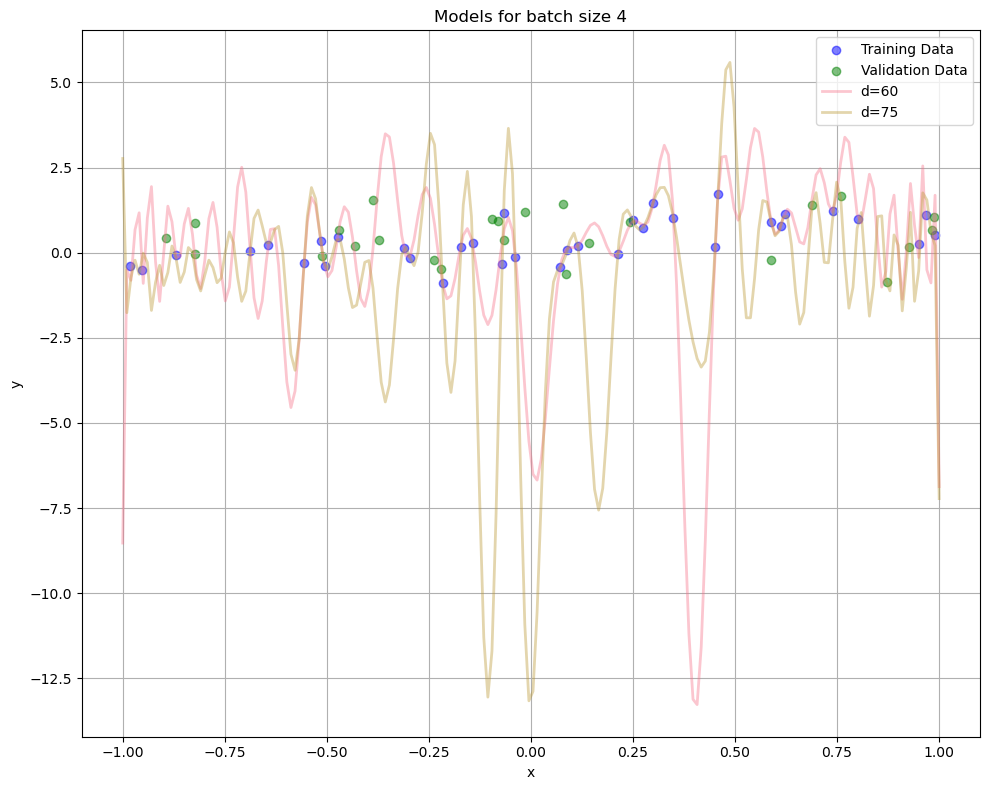

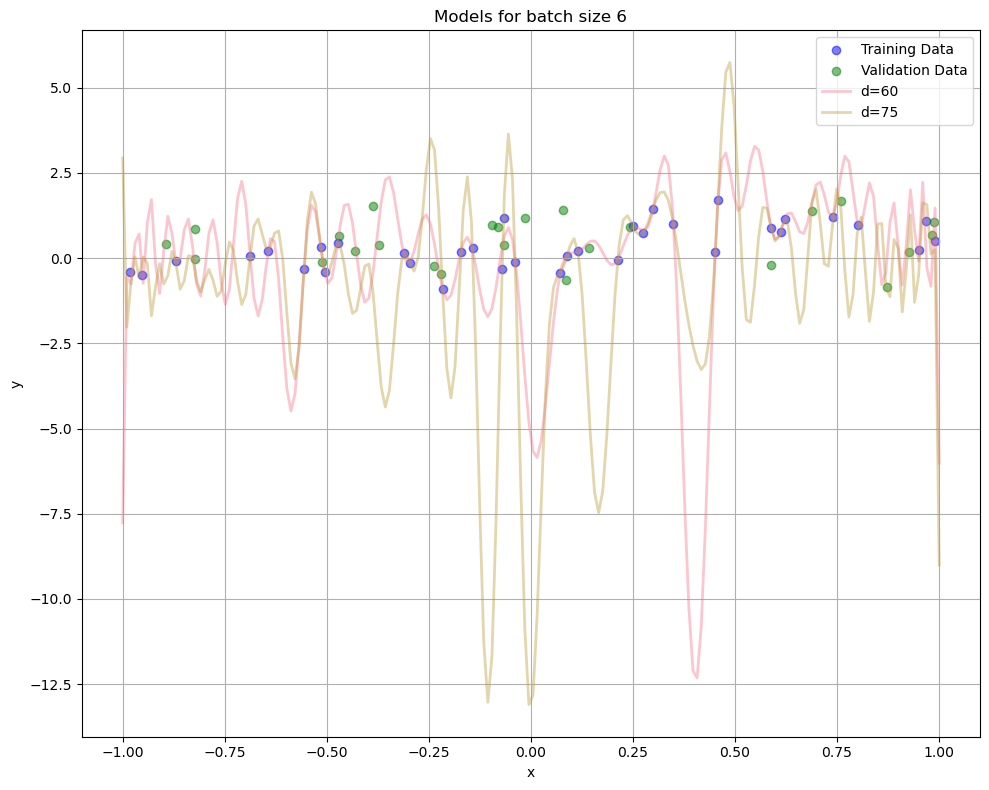

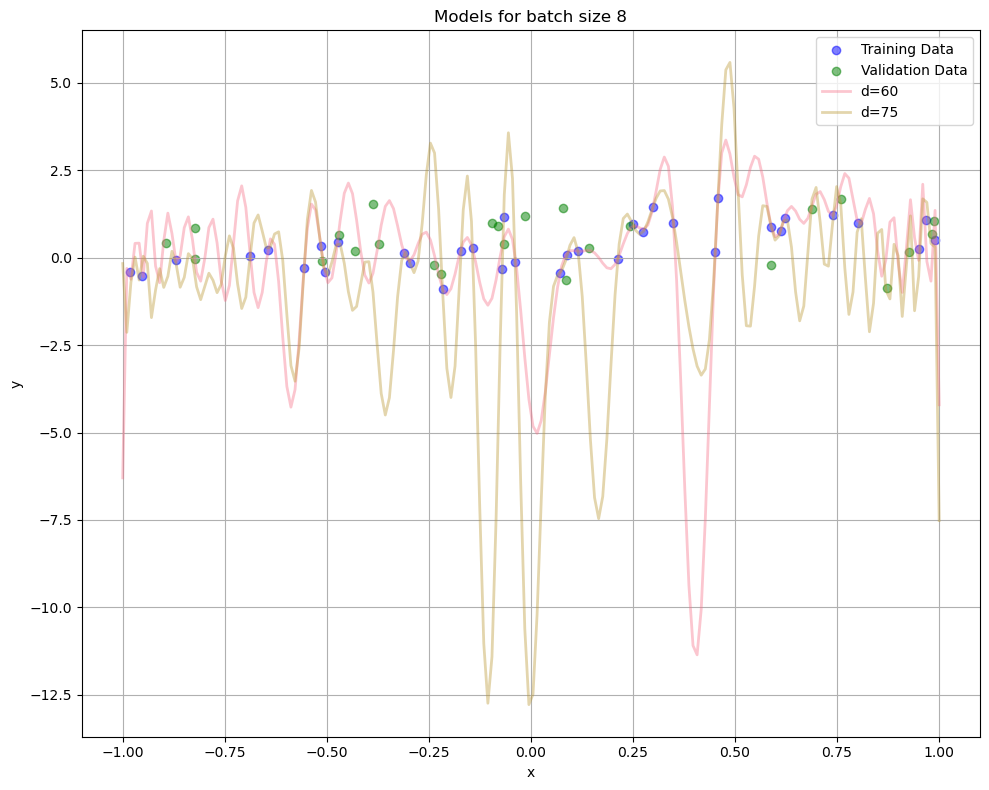

In [36]:
for batch_size in batch_sizes:
    ds = [60, 75]
    dmodels = {}
    for r in results:
        if r['batch_size']==batch_size:
            if int(r['degree']) in ds:
                dmodels[int(r['degree'])] = r['model']
    print(dmodels)
    x_plot = np.linspace(-1, 1, 200)
    Y_pred_dict = {}
    with torch.no_grad():
        X_tensor = torch.tensor(x_plot, dtype=torch.float32).reshape(-1, 1)
        for d in dmodels:
            print(d)
            m = dmodels[d]
            Y_pred_dict[d] = m(X_tensor).numpy()
    plt.figure(figsize = (10,8))
    plt.scatter(x_train, y_train, c='b', label='Training Data', alpha=0.5)
    plt.scatter(x_val, y_val, c='g', label='Validation Data', alpha=0.5)
    for d in ds:
        plt.plot(x_plot, Y_pred_dict[d], label=f'd={d}', linewidth=2, alpha=0.4)
    
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(f'Models for batch size {batch_size}')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()

In [26]:
dmodels

[LegendrePolynomialModel(
   (linear): Linear(in_features=61, out_features=1, bias=True)
 ),
 LegendrePolynomialModel(
   (linear): Linear(in_features=76, out_features=1, bias=True)
 ),
 LegendrePolynomialModel(
   (linear): Linear(in_features=61, out_features=1, bias=True)
 ),
 LegendrePolynomialModel(
   (linear): Linear(in_features=76, out_features=1, bias=True)
 ),
 LegendrePolynomialModel(
   (linear): Linear(in_features=61, out_features=1, bias=True)
 ),
 LegendrePolynomialModel(
   (linear): Linear(in_features=76, out_features=1, bias=True)
 )]